# Pakage

In [1]:
from pandana.loaders import osm
import geopandas as gpd
import pydeck as pdk
import ee
import multiprocessing
from functools import partial
import pandas as pd
import contextily as ctx
from mapbox import Directions
import googlemaps
import plotly.express as px
import h3
from googlemaps import Client as GoogleMaps
from datetime import datetime
import cartopy.crs as ccrs
import seaborn as sns
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from shapely import wkt
import pandana
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

# NYC Shapefile

In [2]:
# New York Sate (FIFP=36) county shapfile data
# url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
nyc_county_data = gpd.read_file('NYC_county/geo_export_6e32161b-8a0a-4cf4-8959-d7a0d8943a54.shp')

In [3]:
url = "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_36_tract.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall()
gdf = gpd.read_file('tl_2020_36_tract.shp')

# Filter the data to include only NYC counties
nyc_counties = ["005", "047", "061", "081", "085"]
nyc_tract_data = gdf[gdf["COUNTYFP"].isin(nyc_counties)]

# Filter out water features (coastline)
nyc_tract_data = nyc_tract_data[nyc_tract_data['ALAND'] > 0]

# Desired variables
nyc_tract_data = nyc_tract_data[["GEOID", "geometry"]]

nyc_tract_data.head()

,GEOID,geometry
0,36047000700,"POLYGON ((-74.00154 40.69279, -74.00132 40.693..."
1,36047000900,"POLYGON ((-73.99405 40.69090, -73.99374 40.691..."
2,36047001100,"POLYGON ((-73.99073 40.69305, -73.99045 40.693..."
3,36047001300,"POLYGON ((-73.99141 40.69863, -73.99131 40.699..."
4,36047002000,"POLYGON ((-74.01867 40.64741, -74.01809 40.647..."


In [4]:
# New York Sate (FIFP=36) block group shapfile data
# url = "https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK20/tl_2020_36_tabblock20.zip"
# response = requests.get(url)
# zip_file = zipfile.ZipFile(io.BytesIO(response.content))
# zip_file.extractall()
gdf = gpd.read_file('NYC_block_group/cb_2022_36_bg_500k.shp')

# Filter the data to include only NYC counties
nyc_counties = ["005", "047", "061", "081", "085"]
nyc_block_data = gdf[gdf["COUNTYFP"].isin(nyc_counties)]

# Filter out water features (coastline)
nyc_block_data = nyc_block_data[nyc_block_data["ALAND"] > 0]

# Desired variables
nyc_block_data = nyc_block_data[["GEOID", "geometry"]]
nyc_block_data.head()

,GEOID,geometry
0,360470200002,"POLYGON ((-74.01026 40.62103, -74.00963 40.621..."
1,360610162004,"POLYGON ((-73.94102 40.78832, -73.94056 40.788..."
3,360470053031,"POLYGON ((-74.01869 40.67968, -74.00838 40.685..."
6,360050161002,"POLYGON ((-73.88511 40.83648, -73.88340 40.835..."
7,360470900003,"POLYGON ((-73.91923 40.66863, -73.91814 40.664..."


# Data

### Replica OD Data

In [5]:
filename = 'nyc_replica.csv'
nyc_mobility = pd.read_csv(filename)

In [6]:
nyc_mobility.head()

,trip_purpose,trip_start_time,trip_end_time,trip_duration_minutes,trip_distance_meters,vehicle_fuel_type,origin_bgrp_fips_2020,origin_bgrp_lat_2020,origin_bgrp_lng_2020,origin_land_use,...,trip_taker_race_ethnicity,trip_taker_education,trip_taker_individual_income,trip_taker_home_bgrp_2020,trip_taker_home_bgrp_fips_2020,trip_taker_home_bgrp_lat_2020,trip_taker_home_bgrp_lng_2020,primary_mode,trip_taker_employment_status,trip_taker_tenure
0,shop,18:26:51,18:36:58,10,3950.461226,unknown_fuel_type,360470218003,40.6357,-74.0000,multi_family,...,white_not_hispanic_or_latino,high_school,1029,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,auto_passenger,employed,renter
1,other_activity_type,17:44:00,18:06:25,22,1869.170793,unknown_fuel_type,360470226001,40.6414,-73.9854,civic_institutional,...,white_not_hispanic_or_latino,high_school,25478,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,walking,employed,renter
2,home,15:09:25,15:19:20,9,827.359951,unknown_fuel_type,360470238002,40.6305,-73.9914,education,...,white_not_hispanic_or_latino,k_12,0,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,walking,under_16,renter
3,work,07:45:00,07:47:05,2,173.658462,unknown_fuel_type,360470218003,40.6357,-74.0000,multi_family,...,white_not_hispanic_or_latino,high_school,21062,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,walking,employed,renter
4,social,12:41:00,12:54:48,13,1951.830741,other_non_bev,360470218003,40.6357,-74.0000,mixed_use,...,white_not_hispanic_or_latino,some_college,11329,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,private_auto,not_in_labor_force,renter


# Data Analysis

### EV  Mobility Exploratory Data Analysis (EV travel mode)

In [7]:
nyc_mobility.primary_mode.unique()

array(['auto_passenger', 'walking', 'private_auto', 'public_transit',
       'on_demand_auto', 'biking', 'other_travel_mode'], dtype=object)

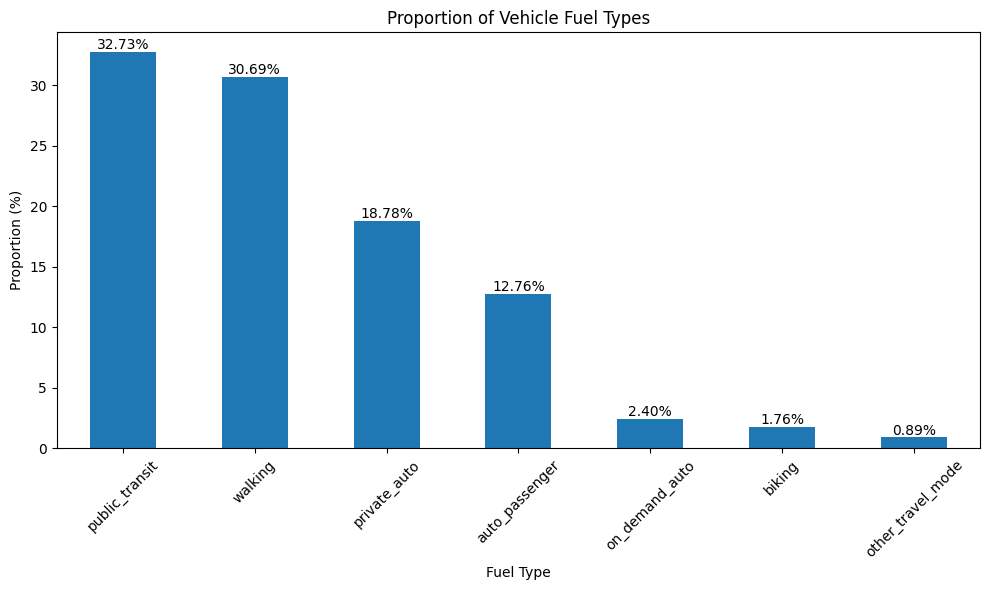

In [8]:
# Count the occurrences of each primary_mode
fuel_type_counts = nyc_mobility['primary_mode'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = (nyc_mobility['primary_mode'].value_counts(normalize=True) * 100).plot(kind='bar')
for p in bars.patches:
    bars.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Proportion of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [9]:
print("Number of trips:", nyc_mobility.shape[0])
print("Number of unique person:", nyc_mobility['trip_taker_person_id'].nunique())
print("Variables:", nyc_mobility['vehicle_fuel_type'].unique())

ev_replica = nyc_mobility[(nyc_mobility['primary_mode'] == 'private_auto') & (nyc_mobility['vehicle_fuel_type'] == 'electric')]
print("Number of EV trips:", ev_replica.shape[0])
print("Number of EV unique person:", ev_replica['trip_taker_person_id'].nunique())

Number of trips: 19243962
Number of unique person: 5423146
Variables: ['unknown_fuel_type' 'other_non_bev' 'electric']
Number of EV trips: 28926
Number of EV unique person: 13369


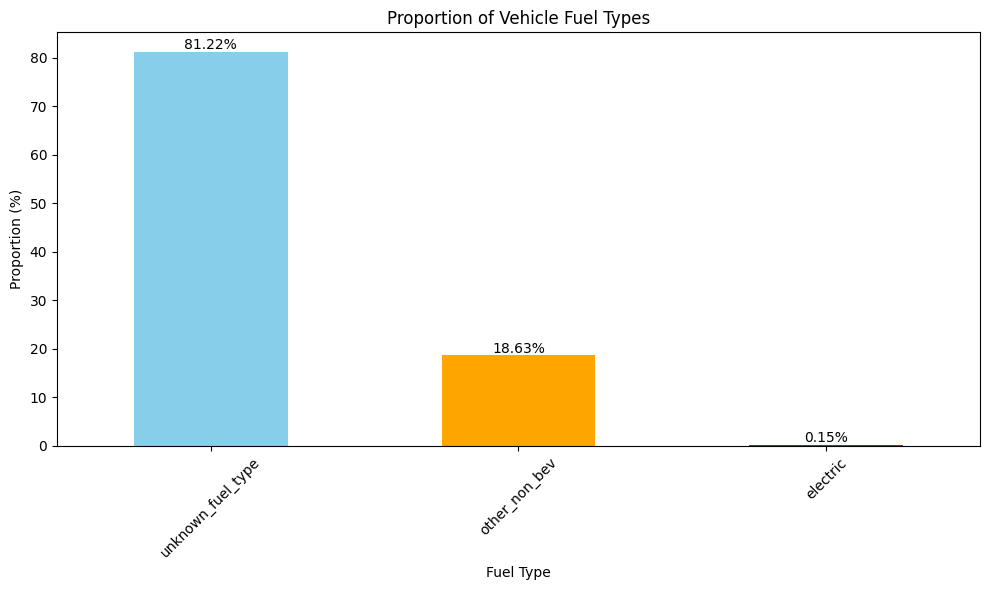

In [10]:
# Count the occurrences of each fuel type
fuel_type_counts = nyc_mobility['vehicle_fuel_type'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = (nyc_mobility['vehicle_fuel_type'].value_counts(normalize=True) * 100).plot(kind='bar', color=['skyblue', 'orange', 'green'])
for p in bars.patches:
    bars.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Proportion of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [11]:
ev_replica['Tract FIPS'] = ev_replica['trip_taker_home_bgrp_fips_2020'].astype(str).str.slice(0, 11)
ev_person = ev_replica.groupby('trip_taker_person_id').apply(lambda x: x.sample(1)).reset_index(drop=True)
ev_person.head()

,trip_purpose,trip_start_time,trip_end_time,trip_duration_minutes,trip_distance_meters,vehicle_fuel_type,origin_bgrp_fips_2020,origin_bgrp_lat_2020,origin_bgrp_lng_2020,origin_land_use,...,trip_taker_education,trip_taker_individual_income,trip_taker_home_bgrp_2020,trip_taker_home_bgrp_fips_2020,trip_taker_home_bgrp_lat_2020,trip_taker_home_bgrp_lng_2020,primary_mode,trip_taker_employment_status,trip_taker_tenure,Tract FIPS
0,shop,14:15:00,14:32:17,17,6235.971059,electric,360810113002,40.7764,-73.9087,mixed_use,...,bachelors_degree,9837,"2 (Tract 113, Queens, NY)",360810113002,40.7764,-73.9087,private_auto,employed,owner,36081011300
1,eat,14:03:00,14:15:43,12,1689.838721,electric,360610093001,40.7471,-73.9990,mixed_use,...,advanced_degree,1027868,"1 (Tract 93, New York, NY)",360610093001,40.7471,-73.9990,private_auto,employed,owner,36061009300
2,shop,17:05:00,17:10:20,5,1927.198516,electric,360610230002,40.8173,-73.9404,mixed_use,...,k_12,0,"1 (Tract 212, New York, NY)",360610212001,40.8154,-73.9378,private_auto,not_in_labor_force,owner,36061021200
3,work,12:01:00,12:08:10,7,1095.383533,electric,360470484002,40.6346,-73.9753,multi_family,...,high_school,24587,"2 (Tract 484, Kings, NY)",360470484002,40.6346,-73.9753,private_auto,employed,owner,36047048400
4,eat,16:37:58,16:43:45,5,1690.823756,electric,360470480002,40.6295,-73.9752,multi_family,...,high_school,119147,"2 (Tract 480, Kings, NY)",360470480002,40.6295,-73.9752,private_auto,employed,renter,36047048000


In [12]:
ev_person['geometry'] = gpd.points_from_xy(ev_person['trip_taker_home_bgrp_lng_2020'], ev_person['trip_taker_home_bgrp_lat_2020'])
ev_person = gpd.GeoDataFrame(ev_person, geometry='geometry')
ev_person.crs = nyc_block_data.crs
merged_data = gpd.sjoin(nyc_block_data, ev_person, how='left', op='contains')

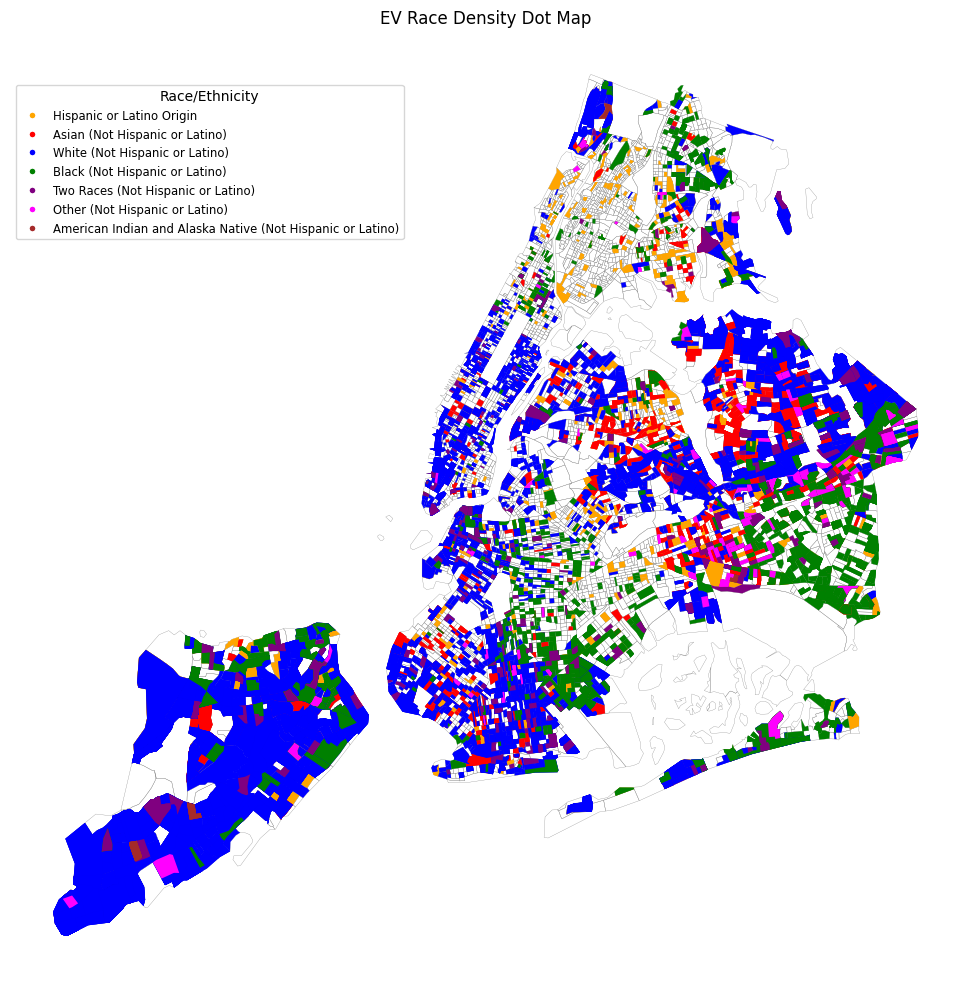

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
nyc_block_data.plot(ax=ax, edgecolor='gray', linewidth=0.2, facecolor='none')

race_colors_labels = {
    'hispanic_or_latino_origin': ('orange', 'Hispanic or Latino Origin'),
    'asian_not_hispanic_or_latino': ('red', 'Asian (Not Hispanic or Latino)'),
    'white_not_hispanic_or_latino': ('blue', 'White (Not Hispanic or Latino)'),
    'black_not_hispanic_or_latino': ('green', 'Black (Not Hispanic or Latino)'),
    'two_races_not_hispanic_or_latino': ('purple', 'Two Races (Not Hispanic or Latino)'),
    'other_not_hispanic_or_latino': ('magenta', 'Other (Not Hispanic or Latino)'),
    'aian_not_hispanic_or_latino': ('brown', 'American Indian and Alaska Native (Not Hispanic or Latino)')
}

# Create a dot map for each race category
for race, (color, label) in race_colors_labels.items():
    race_data = merged_data[merged_data['trip_taker_race_ethnicity'] == race]
    race_data.plot(ax=ax, markersize=1, color=color, label=label)

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=5)
                   for color, label in race_colors_labels.values()]

ax.legend(handles=legend_elements, title='Race/Ethnicity', loc='upper left', fontsize='small', bbox_to_anchor=(0.0, 0.95))
ax.set_title('EV Race Density Dot Map')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [14]:
# Filtering to unique trip takers
unique_trip_takers = merged_data.drop_duplicates(subset='trip_taker_person_id')

# Assuming you have a GeoDataFrame that maps trip taker home locations to their census block geometries
# This might look like: home_locations = gpd.GeoDataFrame(...)
# Ensure the home_locations GeoDataFrame contains the 'geometry' for each census block and the necessary demographic data

# Function to generate random points within a polygon
def generate_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if random_point.within(poly):
            points.append(random_point)
    return points

# Group the unique trip takers by their home census block
grouped_data = unique_trip_takers.groupby('trip_taker_home_bgrp_2020').agg({'trip_taker_race_ethnicity': 'first', 'geometry': 'first', 'trip_taker_person_id': 'count'}).reset_index()

point_list = []
for index, row in grouped_data.iterrows():
    num_people = row['trip_taker_person_id']
    num_dots = num_people // 5  # One dot represents 5 people
    if num_dots > 0:
        points = generate_random_points(row['geometry'], num_dots)
        for point in points:
            point_list.append({'lat': point.y, 'lon': point.x, 'race_ethnicity': row['trip_taker_race_ethnicity']})

# Convert the list of points to a DataFrame for visualization
points_df = pd.DataFrame(point_list)

In [15]:
fig = px.scatter_mapbox(points_df,
                        lat="lat",
                        lon="lon",
                        color="race_ethnicity",
                        color_discrete_map={
                            'hispanic_or_latino_origin': 'orange',
                            'asian_not_hispanic_or_latino': 'red',
                            'white_not_hispanic_or_latino': 'blue',
                            'black_not_hispanic_or_latino': 'green',
                            'two_races_not_hispanic_or_latino': 'purple',
                            'other_not_hispanic_or_latino': 'magenta',
                            'aian_not_hispanic_or_latino': 'brown'
                        },
                        title="Dynamic Race Density Dot Map")

fig.update_layout(mapbox_style="open-street-map", mapbox_zoom=10, mapbox_center={"lat": 40.7128, "lon": -74.0060})
fig.show()

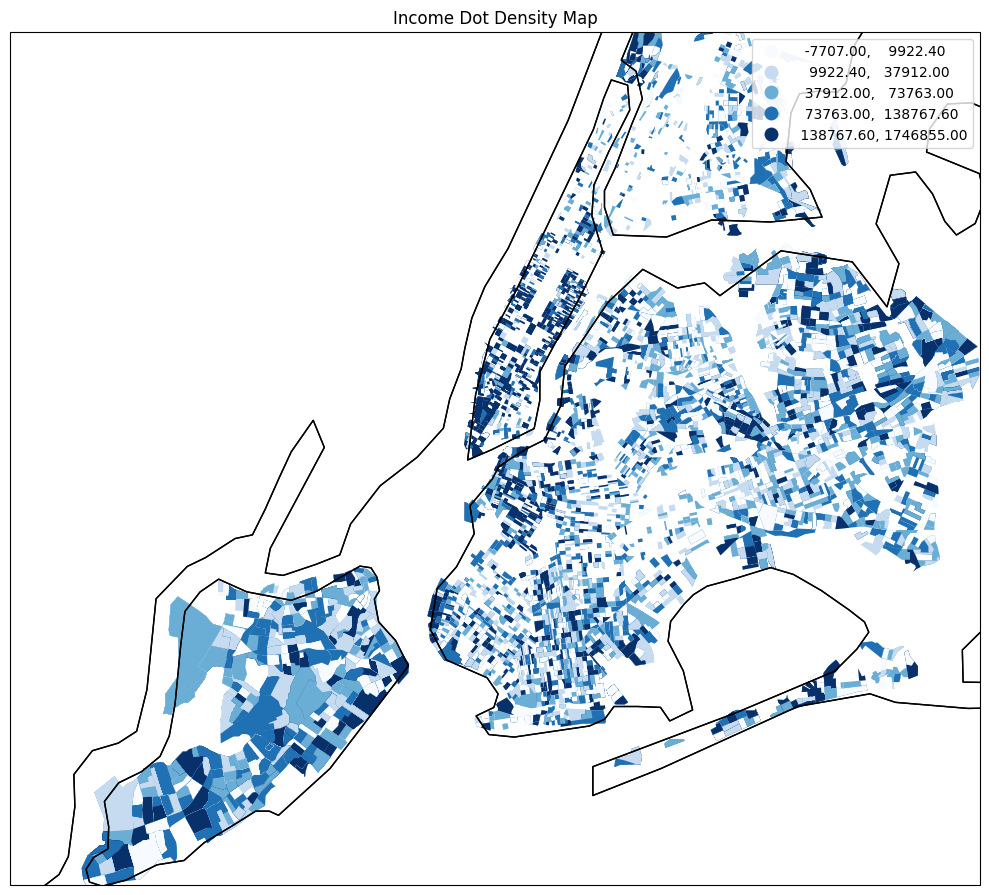

In [16]:
plot_data = gpd.GeoDataFrame(merged_data[['trip_taker_individual_income', 'geometry']], geometry='geometry')
plot_data.crs = "EPSG:4326"

# Create a Cartopy map projection
map_proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=map_proj))
plot_data.plot(ax=ax, column='trip_taker_individual_income', scheme='quantiles', legend=True, cmap='Blues', markersize=1, transform=ccrs.PlateCarree())

# Add basemap features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

# Set the extent of the map
ax.set_extent([-74.3, -73.7, 40.5, 40.9])  # Adjust the coordinates to focus on NYC
ax.set_title('Income Dot Density Map')
plt.tight_layout()
plt.show()

### EV CO2

In [17]:
CO2_EMISSION_FACTORS = {
    'walking': 0,  # Negligible for direct emissions
    'biking': 0,  # Negligible for direct emissions
    'public_transit': 36.5,  # Average of bus and rail
    'private_auto': 175,  #  EV
    'other_non_bev': 251  # Average for gasoline cars
}

block_shapefile = nyc_block_data
block_shapefile['co2_emissions'] = 0

CO2 = ev_replica[['primary_mode', 'trip_distance_meters',
                  'origin_bgrp_fips_2020', 'origin_bgrp_lat_2020', 'origin_bgrp_lng_2020',
                  'destination_bgrp_fips_2020', 'destination_bgrp_lat_2020', 'destination_bgrp_lng_2020']]

# Map primary_mode to CO2 emission factors
CO2['emission_factor'] = CO2['primary_mode'].map(CO2_EMISSION_FACTORS)

# Calculate CO2 emissions in grams
CO2['co2_emissions_grams'] = (CO2['trip_distance_meters'] / 1000) * CO2['emission_factor']

CO2.head()

,primary_mode,trip_distance_meters,origin_bgrp_fips_2020,origin_bgrp_lat_2020,origin_bgrp_lng_2020,destination_bgrp_fips_2020,destination_bgrp_lat_2020,destination_bgrp_lng_2020,emission_factor,co2_emissions_grams
817,private_auto,2869.861115,360470129014,40.6826,-73.9779,360470317011,40.6748,-73.9500,175.0,502.225695
932,private_auto,1958.449908,360470414022,40.6022,-73.9686,360470582002,40.5973,-73.9600,175.0,342.728734
1399,private_auto,11542.946199,360810590001,40.7013,-73.7370,360810716001,40.6469,-73.7869,175.0,2020.015585
1410,private_auto,3616.697673,360811467002,40.7609,-73.7733,360811479001,40.7725,-73.7380,175.0,632.922093
1819,private_auto,1931.481372,360810997051,40.7875,-73.7860,360810997044,40.7799,-73.7776,175.0,338.009240


In [18]:
# CO2.to_csv('NYC_EV_CO2.csv')

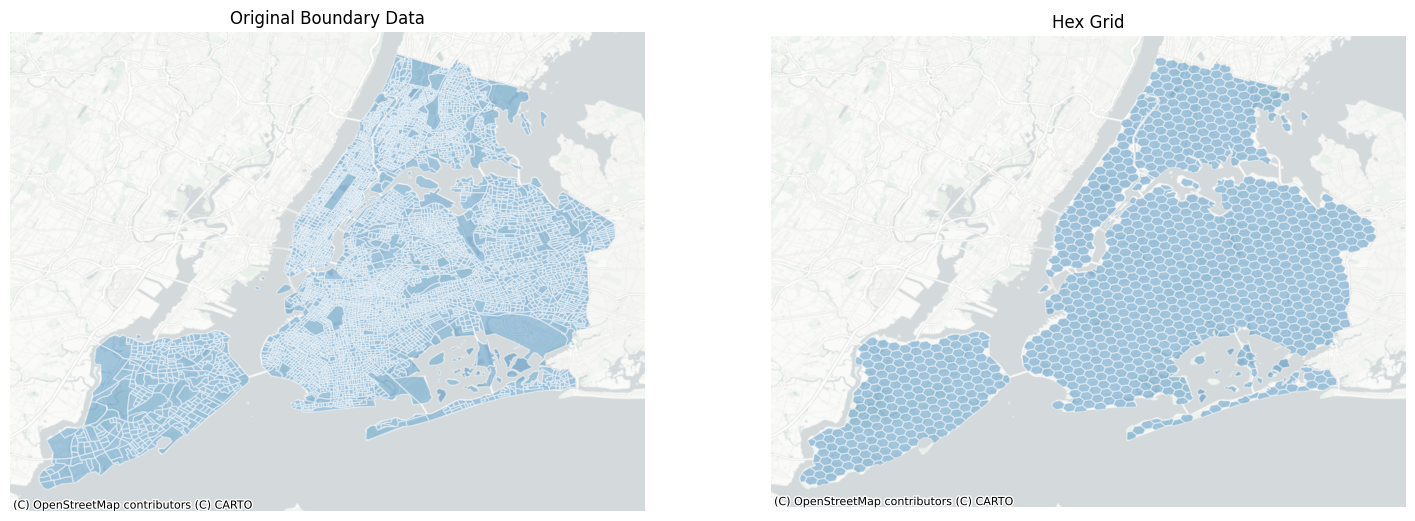

In [19]:
block = nyc_block_data
hexes = h3fy(block, resolution=8, clip=True)  # 8: edge length of approximately 0.74 km and spans an area of approximately 3 km²

fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

block.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Boundary Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.CartoDB.PositronNoLabels)
    axs[i].axis('off')

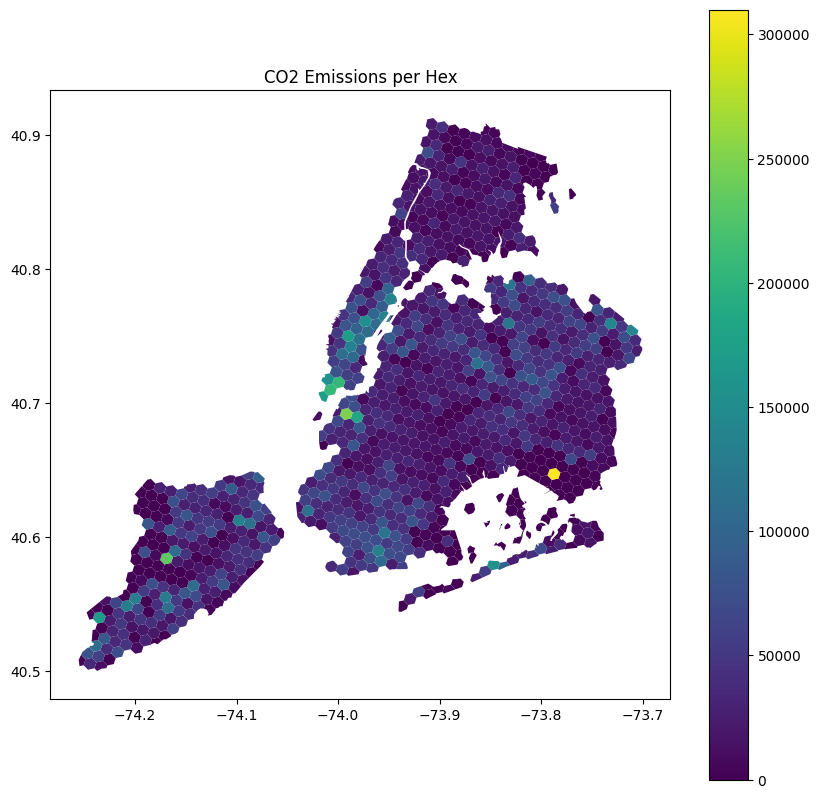

In [21]:
# Assign to OD hex
hexes = hexes.reset_index()
CO2['origin_geom'] = [Point(xy) for xy in zip(CO2['origin_bgrp_lng_2020'], CO2['origin_bgrp_lat_2020'])]
CO2['destination_geom'] = [Point(xy) for xy in zip(CO2['destination_bgrp_lng_2020'], CO2['destination_bgrp_lat_2020'])]
CO2_orig_geo = gpd.GeoDataFrame(CO2, geometry='origin_geom', crs=hexes.crs)
CO2_dest_geo = gpd.GeoDataFrame(CO2, geometry='destination_geom', crs=hexes.crs)

# Spatial join for origins and destinations
CO2_origins = gpd.sjoin(CO2_orig_geo, hexes, how="left", op='intersects')
CO2_destinations = gpd.sjoin(CO2_dest_geo, hexes, how="left", op='intersects', rsuffix='dest')

# Assign emissions to each hex, splitting emissions between origin and destination hexes
CO2_origins['emissions_per_hex'] = CO2_origins['co2_emissions_grams'] / 2  # Simplified assumption
CO2_destinations['emissions_per_hex'] = CO2_destinations['co2_emissions_grams'] / 2

# Combine data from origins and destinations
total_emissions = pd.concat([
    CO2_origins[['hex_id', 'emissions_per_hex']], 
    CO2_destinations[['hex_id', 'emissions_per_hex']]
])

# Aggregate emissions by hex ID
total_emissions = total_emissions.groupby('hex_id').sum().reset_index()

# Merge the total emissions with the hexes GeoDataFrame
hexes = hexes.merge(total_emissions, on='hex_id', how='left')

# Replace NaN values with zero for hexes without any trip emissions
hexes['emissions_per_hex'].fillna(0, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hexes.plot(column='emissions_per_hex', cmap='viridis', legend=True, ax=ax)
ax.set_title('CO2 Emissions per Hex')
plt.show()

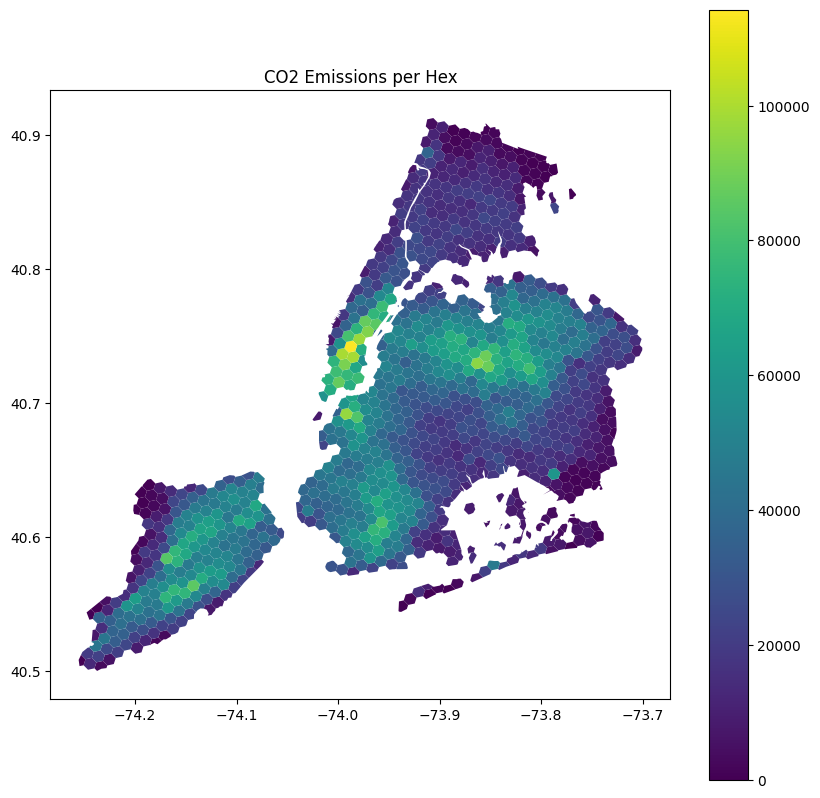

In [23]:
# Assign to OD straight Lingstring hex

# hexes = hexes.reset_index()
CO2['trip_id'] = CO2.index

# Create LineStrings from origin to destination points
CO2['line_geom'] = [LineString([Point(xy1), Point(xy2)]) for xy1, xy2 in zip(
    zip(CO2['origin_bgrp_lng_2020'], CO2['origin_bgrp_lat_2020']),
    zip(CO2['destination_bgrp_lng_2020'], CO2['destination_bgrp_lat_2020'])
)]

# Convert to GeoDataFrame
CO2_geo = gpd.GeoDataFrame(CO2, geometry='line_geom', crs=hexes.crs)

# Perform overlay operation
intersections = gpd.overlay(CO2_geo, hexes[['hex_id', 'geometry']], how='intersection', keep_geom_type=False)

# Calculate emissions per intersected hex
intersections['count'] = intersections.groupby('trip_id')['geometry'].transform('count')
intersections['emissions_per_hex'] = intersections['co2_emissions_grams'] / intersections['count']
total_emissions = intersections.groupby('hex_id')['emissions_per_hex'].sum().reset_index()

# Reset index before merging to avoid ambiguity
hexes = hexes.reset_index(drop=True)
total_emissions = total_emissions.reset_index(drop=True)

# Merge with hexes and replace NaN values with zero
hexes = hexes.merge(total_emissions, on='hex_id', how='left')
hexes['emissions_per_hex'].fillna(0, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hexes.plot(column='emissions_per_hex', cmap='viridis', legend=True, ax=ax)
ax.set_title('CO2 Emissions per Hex')
plt.show()

In [24]:
CO2_EMISSION_FACTORS = {
    'walking': 0,  # Negligible for direct emissions
    'biking': 0,  # Negligible for direct emissions
    'public_transit': 36.5,  # Average of bus and rail
    'private_auto': 175,  #  EV
    'other_non_bev': 251  # Average for gasoline cars
}

block_shapefile = nyc_block_data
block_shapefile['co2_emissions'] = 0

CO2 = ev_replica[['primary_mode', 'trip_distance_meters',
                  'origin_bgrp_fips_2020', 'origin_bgrp_lat_2020', 'origin_bgrp_lng_2020',
                  'destination_bgrp_fips_2020', 'destination_bgrp_lat_2020', 'destination_bgrp_lng_2020']]

# Map primary_mode to CO2 emission factors
CO2['emission_factor'] = CO2['primary_mode'].map(CO2_EMISSION_FACTORS)

# Calculate CO2 emissions in grams
CO2['co2_emissions_grams'] = (CO2['trip_distance_meters'] / 1000) * CO2['emission_factor']
block = nyc_block_data
hexes = h3fy(block, resolution=8, clip=True)  # 8: edge length of approximately 0.74 km and spans an area of approximately 3 km²

In [ ]:
access_token = '' # Mapbox API token
directions_service = Directions(access_token=access_token)

def fetch_routes(batch):
    """ Fetch routes for a batch of origins and destinations """
    results = []
    for origin, destination in batch:
        response = directions_service.directions([origin, destination], 'mapbox/driving')
        if response.status_code == 200:
            route = response.geojson()['features'][0]['geometry']
            results.append(LineString(route['coordinates']))
        else:
            results.append(None)
    return results

CO2 = CO2[['origin_bgrp_lng_2020', 'origin_bgrp_lat_2020', 'destination_bgrp_lng_2020', 'destination_bgrp_lat_2020', 'co2_emissions_grams']]

# Creating tuples of origin and destination points
points = [
    (Point(row['origin_bgrp_lng_2020'], row['origin_bgrp_lat_2020']),
     Point(row['destination_bgrp_lng_2020'], row['destination_bgrp_lat_2020']))
    for index, row in CO2.iterrows()
]

In [ ]:
# Process in batches using multiprocessing
cpu_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cpu_cores)
batch_size = len(points) // cpu_cores
batches = [points[i:i + batch_size] for i in range(0, len(points), batch_size)]
routes = pool.map(fetch_routes, batches)
pool.close()
pool.join()

In [ ]:
# Flatten the list of routes
routes = [route for batch in routes for route in batch]
CO2['shortest_path'] = routes

# Convert to GeoDataFrame
CO2_geo = gpd.GeoDataFrame(CO2, geometry='shortest_path', crs='EPSG:4326')
CO2_geo['trip_id'] = CO2_geo.index

In [ ]:
# Initialize the Directions service with Mapbox access token
access_token = ''
directions_service = Directions(access_token=access_token)

def fetch_route(origin, destination):
    """ Fetch the shortest path using Mapbox Directions API """
    response = directions_service.directions([origin, destination], 'mapbox/driving')
    if response.status_code == 200:
        # Extract route as LineString if the response is successful
        routes = response.geojson()['features'][0]['geometry']
        return LineString(routes['coordinates'])
    else:
        return None

CO2 = CO2[['origin_bgrp_lng_2020',	'origin_bgrp_lat_2020', 'destination_bgrp_lng_2020', 'destination_bgrp_lat_2020', 'co2_emissions_grams']]
CO2.shape

In [ ]:
# sampled_data = CO2.sample(n=1000, random_state=42)  # sampled_data = CO2.sample(frac=0.1)

# Use apply to create a new column 'shortest_path' with the LineString of the route
CO2['shortest_path'] = CO2.apply(lambda row: fetch_route(
    {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['origin_bgrp_lng_2020'], row['origin_bgrp_lat_2020']]}},
    {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['destination_bgrp_lng_2020'], row['destination_bgrp_lat_2020']]}
    }), axis=1)

# Convert CO2 to a GeoDataFrame with the new 'shortest_path' geometry
CO2_geo = gpd.GeoDataFrame(CO2, geometry='shortest_path', crs=hexes.crs)
CO2_geo['trip_id'] = CO2_geo.index
CO2_geo.head()

### Filtered Mobility Data Analysis (All types travel mode)

In [28]:
desired_modes = ['walking', 'public_transit', 'biking', 'private_auto']
filtered = nyc_mobility[nyc_mobility['primary_mode'].isin(desired_modes)]
# Change 'private_auto' in 'primary_mode' to 'other_non_bev' or 'electric' based on 'vehicle_fuel_type'
filtered.loc[filtered['primary_mode'] == 'private_auto', 'primary_mode'] = filtered['vehicle_fuel_type']
filtered.head()

,trip_purpose,trip_start_time,trip_end_time,trip_duration_minutes,trip_distance_meters,vehicle_fuel_type,origin_bgrp_fips_2020,origin_bgrp_lat_2020,origin_bgrp_lng_2020,origin_land_use,...,trip_taker_race_ethnicity,trip_taker_education,trip_taker_individual_income,trip_taker_home_bgrp_2020,trip_taker_home_bgrp_fips_2020,trip_taker_home_bgrp_lat_2020,trip_taker_home_bgrp_lng_2020,primary_mode,trip_taker_employment_status,trip_taker_tenure
1,other_activity_type,17:44:00,18:06:25,22,1869.170793,unknown_fuel_type,360470226001,40.6414,-73.9854,civic_institutional,...,white_not_hispanic_or_latino,high_school,25478,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,walking,employed,renter
2,home,15:09:25,15:19:20,9,827.359951,unknown_fuel_type,360470238002,40.6305,-73.9914,education,...,white_not_hispanic_or_latino,k_12,0,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,walking,under_16,renter
3,work,07:45:00,07:47:05,2,173.658462,unknown_fuel_type,360470218003,40.6357,-74.0000,multi_family,...,white_not_hispanic_or_latino,high_school,21062,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,walking,employed,renter
4,social,12:41:00,12:54:48,13,1951.830741,other_non_bev,360470218003,40.6357,-74.0000,mixed_use,...,white_not_hispanic_or_latino,some_college,11329,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,other_non_bev,not_in_labor_force,renter
5,school,08:57:25,09:16:59,19,1631.458788,unknown_fuel_type,360470218003,40.6357,-74.0000,single_family,...,white_not_hispanic_or_latino,no_school,0,"3 (Tract 218, Kings, NY)",360470218003,40.6357,-74.0,walking,under_16,renter


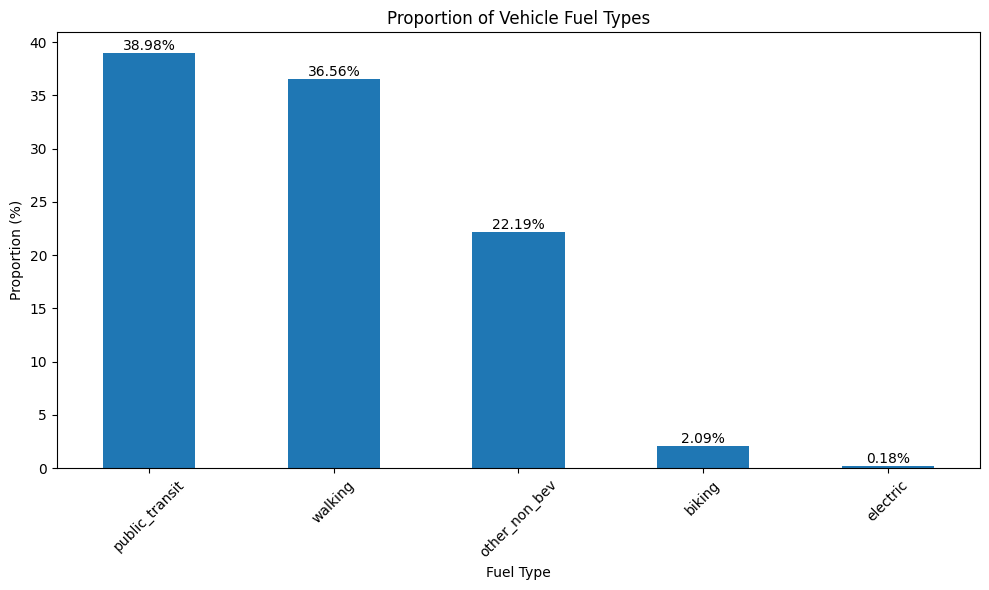

In [29]:
# Count the occurrences of each primary_mode
fuel_type_counts = filtered['primary_mode'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = (filtered['primary_mode'].value_counts(normalize=True) * 100).plot(kind='bar')
for p in bars.patches:
    bars.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Proportion of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [30]:
filtered.primary_mode.unique()

array(['walking', 'other_non_bev', 'public_transit', 'biking', 'electric'],
      dtype=object)

In [31]:
filtered.columns

Index(['trip_purpose', 'trip_start_time', 'trip_end_time',
       'trip_duration_minutes', 'trip_distance_meters', 'vehicle_fuel_type',
       'origin_bgrp_fips_2020', 'origin_bgrp_lat_2020', 'origin_bgrp_lng_2020',
       'origin_land_use', 'destination_bgrp_fips_2020',
       'destination_bgrp_lat_2020', 'destination_bgrp_lng_2020',
       'destination_land_use', 'trip_taker_person_id', 'trip_taker_age',
       'trip_taker_sex', 'trip_taker_race_ethnicity', 'trip_taker_education',
       'trip_taker_individual_income', 'trip_taker_home_bgrp_2020',
       'trip_taker_home_bgrp_fips_2020', 'trip_taker_home_bgrp_lat_2020',
       'trip_taker_home_bgrp_lng_2020', 'primary_mode',
       'trip_taker_employment_status', 'trip_taker_tenure'],
      dtype='object')

In [32]:
filtered[['trip_taker_home_bgrp_2020','trip_taker_home_bgrp_fips_2020']].head()

,trip_taker_home_bgrp_2020,trip_taker_home_bgrp_fips_2020
1,"3 (Tract 218, Kings, NY)",360470218003
2,"3 (Tract 218, Kings, NY)",360470218003
3,"3 (Tract 218, Kings, NY)",360470218003
4,"3 (Tract 218, Kings, NY)",360470218003
5,"3 (Tract 218, Kings, NY)",360470218003


##### CO2 Emmission

In [33]:
CO2_EMISSION_FACTORS = {
    'walking': 0,  # Negligible for direct emissions
    'biking': 0,  # Negligible for direct emissions
    'public_transit': 36.5,  # Average of bus and rail
    'electric': 175,  # Assumed national average, adjust based on specific electricity mix
    'other_non_bev': 251  # Average for gasoline cars
}

In [34]:
CO2 = filtered[['trip_start_time','trip_duration_minutes','primary_mode','trip_distance_meters',
                    'origin_bgrp_fips_2020','origin_bgrp_lat_2020','origin_bgrp_lng_2020',
                    'destination_bgrp_fips_2020','destination_bgrp_lat_2020','destination_bgrp_lng_2020',
                    'trip_taker_home_bgrp_fips_2020', 'trip_taker_home_bgrp_lat_2020','trip_taker_home_bgrp_lng_2020',
                     'trip_taker_person_id','trip_taker_age','trip_taker_sex','trip_taker_race_ethnicity','trip_taker_education','trip_taker_individual_income']]

# Map primary_mode to CO2 emission factors
CO2['emission_factor'] = CO2['primary_mode'].map(CO2_EMISSION_FACTORS)

# Calculate CO2 emissions in grams
CO2['co2_emissions_grams'] = (CO2['trip_distance_meters'] / 1000) * CO2['emission_factor']
CO2.head()

,trip_start_time,trip_duration_minutes,primary_mode,trip_distance_meters,origin_bgrp_fips_2020,origin_bgrp_lat_2020,origin_bgrp_lng_2020,destination_bgrp_fips_2020,destination_bgrp_lat_2020,destination_bgrp_lng_2020,...,trip_taker_home_bgrp_lat_2020,trip_taker_home_bgrp_lng_2020,trip_taker_person_id,trip_taker_age,trip_taker_sex,trip_taker_race_ethnicity,trip_taker_education,trip_taker_individual_income,emission_factor,co2_emissions_grams
1,17:44:00,22,walking,1869.170793,360470226001,40.6414,-73.9854,360470218003,40.6357,-74.0000,...,40.6357,-74.0,7171676530233297715,19,female,white_not_hispanic_or_latino,high_school,25478,0.0,0.000000
2,15:09:25,9,walking,827.359951,360470238002,40.6305,-73.9914,360470218003,40.6357,-74.0000,...,40.6357,-74.0,17586387235822931728,13,male,white_not_hispanic_or_latino,k_12,0,0.0,0.000000
3,07:45:00,2,walking,173.658462,360470218003,40.6357,-74.0000,360470218003,40.6357,-74.0000,...,40.6357,-74.0,7904809194130997811,30,male,white_not_hispanic_or_latino,high_school,21062,0.0,0.000000
4,12:41:00,13,other_non_bev,1951.830741,360470218003,40.6357,-74.0000,360470190001,40.6228,-73.9992,...,40.6357,-74.0,7824204346816725785,22,female,white_not_hispanic_or_latino,some_college,11329,251.0,489.909516
5,08:57:25,19,walking,1631.458788,360470218003,40.6357,-74.0000,360470102002,40.6388,-74.0138,...,40.6357,-74.0,5417301622702824191,3,female,white_not_hispanic_or_latino,no_school,0,0.0,0.000000


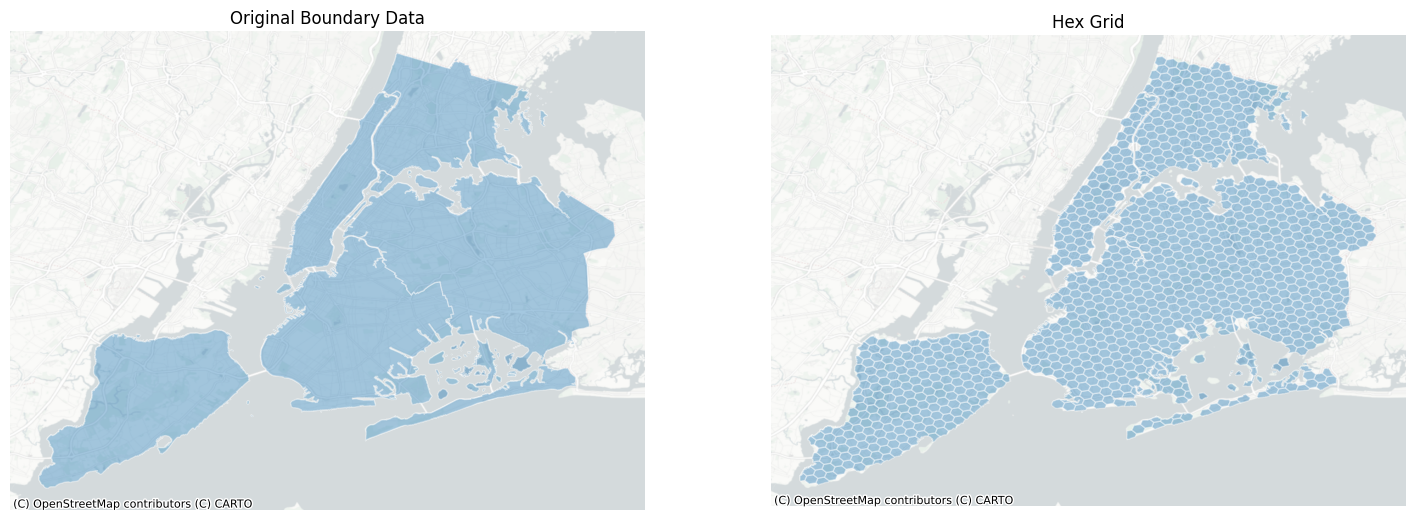

In [35]:
county = nyc_county_data
hexes = h3fy(county, resolution=8, clip=True)  # edge length of approximately 0.74 km and spans an area of approximately 3 km²

fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

county.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Boundary Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.CartoDB.PositronNoLabels)
    axs[i].axis('off')

In [36]:
hexes.shape

(1055, 1)

# Primary Mode

In [37]:
# Filtering data based on 'primary_mode'
CO2_gascar = CO2[CO2['primary_mode'] == 'other_non_bev']
CO2_walk = CO2[CO2['primary_mode'] == 'walking']
CO2_transit = CO2[CO2['primary_mode'] == 'public_transit']
CO2_bike = CO2[CO2['primary_mode'] == 'biking']
CO2_ev = CO2[CO2['primary_mode'] == 'electric']

# Exporting to CSV
#CO2_gascar.to_csv('CO2_gascar.csv', index=False)
#CO2_walk.to_csv('CO2_walk.csv', index=False)
#CO2_transit.to_csv('CO2_transit.csv', index=False)
#CO2_bike.to_csv('CO2_bike.csv', index=False)
#CO2_ev.to_csv('CO2_ev.csv', index=False)